In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
from matplotlib import pyplot as plt, dates as mdates


In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# Inspect the engine to find table names:
inspector = inspect(engine)
print(inspector.get_table_names())
# View all of the classes that automap found for 'station' table:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])


['measurement', 'station']
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# View all of the classes that automap found for 'measurement' table:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
qry_date_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f"The most recent date in the data set: {qry_date_recent}")

The most recent date in the data set: ('2017-08-23',)


Query Date Most Recent:  ('2017-08-23',)
Query Date Year Before:  2016-08-23


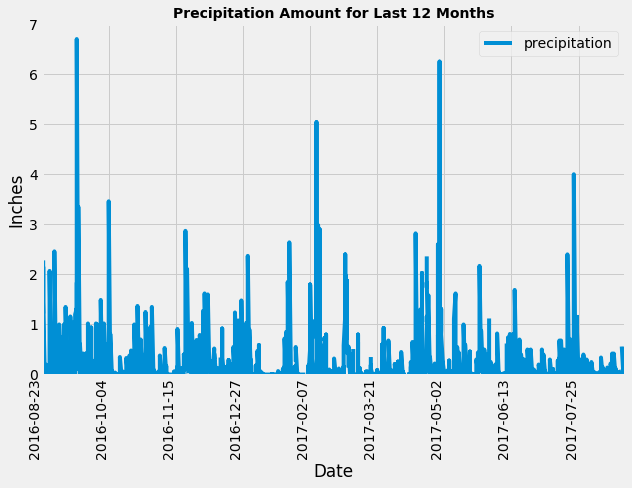

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
print("Query Date Most Recent: ", qry_date_recent)
# Calculate the date one year from the last date in data set.
qry_date_yearBefore = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
print("Query Date Year Before: ", qry_date_yearBefore)

# Perform a query to retrieve the data and precipitation scores
prcp_date_qry = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= dt.date(2016, 8, 23)).\
    filter(measurement.date <= dt.date(2017, 8, 23)).order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_date_qry, columns=['date', 'precipitation'])
prcp_df.set_index('date', inplace=True)
prcp_df.index = pd.to_datetime(prcp_df.index, format="%Y/%m/%d")

# Sort the dataframe by date
prcp_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
# Set fig and axis, and figure size:
fig, ax = plt.subplots(figsize=(9, 7))
# pandas plot:
prcp_df_plot = prcp_df.plot(ax=ax, ylim=(0,7), rot=90)
# Format x label for dates: 
# Define the date format and set it to the x-axis:
date_form = mdates.DateFormatter("%Y-%m-%d") 
ax.set_xlim([dt.date(2016, 8, 23), dt.date(2017, 8, 23)])
ax.xaxis.set_major_formatter(date_form)
# Ensure a major tick for every 6 weeks using (interval=6) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=6))

# Add titles:
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation Amount for Last 12 Months",size=14, weight="bold")

plt.tight_layout()
#  Save plot as png:
plt.savefig("Images/prcp_df_plot.png")
plt.show()


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_prcp_df = prcp_df.describe()
summary_prcp_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
# session.query(func.count(station.station)).all()
total_stations = session.query(station.station).count()
print(f"The total number of stations in the dataset is: {total_stations} stations.")

The total number of stations in the dataset is: 9 stations.


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_counts = session.query(station.station, func.count(measurement.station)).filter(measurement.station == station.station).group_by(station.station).\
    order_by(func.count(station.station).desc()).all()

print(f"The stations and the counts in descending order:")
station_counts

The stations and the counts in descending order:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_id = station_counts[0][0]
most_activeStation = session.query(measurement.station, func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
    filter(measurement.station == most_id).all()
most_activeStation
print(f"The most active station id is: {most_activeStation[0][0]}. The lowest temperature recorded at that station was {most_activeStation[0][1]}. The highest was {most_activeStation[0][2]}, and the average temperature for station {most_activeStation[0][0]} was {round(most_activeStation[0][3],2)}")

The most active station id is: USC00519281. The lowest temperature recorded at that station was 54.0. The highest was 85.0, and the average temperature for station USC00519281 was 71.66


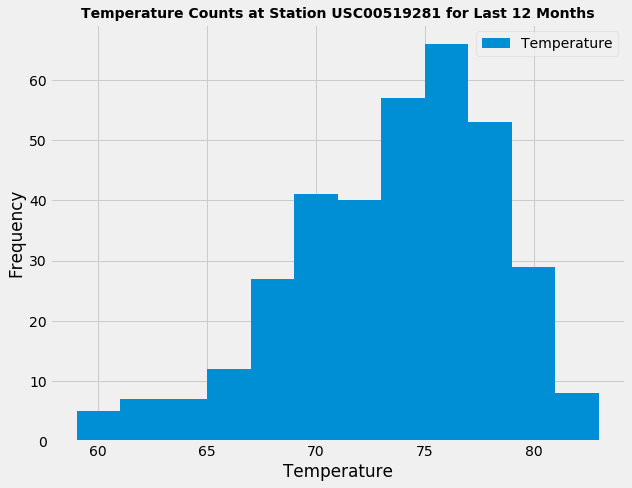

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram:
most_active_year_qry = session.query(measurement.station, measurement.tobs).\
    filter(measurement.station == most_id).\
    filter(measurement.date >= dt.date(2016, 8, 23)).\
    filter(measurement.date <= dt.date(2017, 8, 23)).order_by(measurement.tobs).all()
most_active_year_qry
# Save the query results as a Pandas DataFrame:
active_year_df = pd.DataFrame(most_active_year_qry, columns=['Station', 'Temperature'])
active_year_df

# plot the histogram:
fig, ax = plt.subplots(figsize=(9, 7))
# pandas plot:
hist_active_plot = active_year_df.plot.hist(ax=ax, bins=12)
# Add x-axis title:
plt.xlabel("Temperature")
plt.title(f"Temperature Counts at Station {most_activeStation[0][0]} for Last 12 Months",size=14, weight="bold")
plt.tight_layout()
#  Save plot as png:
plt.savefig("Images/hist_active_plot.png")
plt.show()

# Close session

In [18]:
# Close Session
session.close() 